In [ ]:
#!pip install tensorflow==2.1

%load_ext tensorboard
%tensorflow_version 2.x

!rm -r ./graphs/*


rm: cannot remove './graphs/*': No such file or directory


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import re #regex

import nltk
from tensorflow.keras.preprocessing.text import Tokenizer,text_to_word_sequence
from tensorflow.keras.models import load_model, Model,Sequential
from tensorflow.keras.layers import Dense,Reshape, Activation, Dropout, Input, LSTM, Dense,Embedding,Flatten, Bidirectional
from tensorflow.keras.initializers import glorot_uniform,Constant
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint,LambdaCallback
from google.colab import files
import random
import sys
import io
from tensorflow.keras.preprocessing.sequence import pad_sequences 
import os
import multiprocessing
from gensim.models import Word2Vec
import string


from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer

from tensorflow.keras.utils import to_categorical
nltk.download('punkt')
nltk.download('stopwords')

from google.colab import drive
drive.mount('/content/drive')


#!pip install livelossplot
#!pip install git+git://github.com/stared/livelossplot.git
#from livelossplot.tf_keras import PlotLossesCallback


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)




Running on TPU  ['10.75.170.186:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.75.170.186:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.75.170.186:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [ ]:
max_words = 10
MIN_WORD_FREQUENCY = 10
buffer_size = 10000
batch_size=64*tpu_strategy.num_replicas_in_sync
emb_dim=300 #The dimensionality of our embeddings
window= 5 #This determines which words are considered contexts of the target. For the window of size n the contexts are defined by capturing n words to the left of the target and n words to its right.
min_count =1 #We can use this parameter to tell the model to ignore some infrequent words — don’t create an embedding for them and don’t include them as contexts. 
negative = 10 #Defines the number of negative samples (incorrect training pair instances) that are drawn for each good sample (see the Skip-gram section)
iterator = 1000 #How many epochs do we want to train for — how many times we want to pass through our training data. 

In [ ]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

def prepare_data():
  with io.open("/content/drive/My Drive/Colab Notebooks/Portfolio/TextGenerator/nietzsche.txt", encoding='utf-8') as f:
    text = ((((f.read().lower().replace('\n', ' \n ')).replace('?', ' ? ')).replace('.', ' . ')).replace(',', ' , ')).replace('!', ' ! ')#.splitlines()
  print('corpus length:', len(text))
  print('corpus:', text)  

  return text

#review_lines ,text= prepare_data()
text= prepare_data()



corpus length: 643871
corpus: supposing that truth is a woman--what then ?  is there not ground 
 for suspecting that all philosophers ,  in so far as they have been 
 dogmatists ,  have failed to understand women--that the terrible 
 seriousness and clumsy importunity with which they have usually paid 
 their addresses to truth ,  have been unskilled and unseemly methods for 
 winning a woman ?  certainly she has never allowed herself to be won; and 
 at present every kind of dogma stands with sad and discouraged mien--if ,  
 indeed ,  it stands at all !  for there are scoffers who maintain that it 
 has fallen ,  that all dogma lies on the ground--nay more ,  that it is at 
 its last gasp .  but to speak seriously ,  there are good grounds for hoping 
 that all dogmatizing in philosophy ,  whatever solemn ,  whatever conclusive 
 and decided airs it has assumed ,  may have been only a noble puerilism 
 and tyronism; and probably the time is at hand when it will be once 
 and again u

In [ ]:
def train_embedding(review_lines):
  # Get text corpus

  workers = multiprocessing.cpu_count()#Determines how many worker threads will be used to train the model.
  print("workers",workers)
  model = Word2Vec(sentences=review_lines, size=emb_dim, window=window, min_count =min_count, negative=negative, iter=iterator, workers =workers) 
  word_vectors = model.wv #get trained embeddings  - an KeyedVectors instance
  filename = "/content/drive/My Drive/Colab Notebooks/Portfolio/TextGenerator/imbeddingsVecTrained.txt"

  model.wv.save_word2vec_format(filename,binary=False)
      
  return word_vectors
  
#word_vectors = train_embedding(review_lines)

In [ ]:
def tokenize_dataset(text):

  """****************************************************************************
  Convert the word selected to train word embeddings into tokenized vector to pass to embedding layer 
  ******************************************************************************"""
  tokenizer = Tokenizer(filters='"#$%&()*+-/<=>@[\\]_`{|}:',lower=True,split=' ', char_level=False )
  text = [text]
  tokenizer.fit_on_texts(text)
  sequences = tokenizer.texts_to_sequences(text)[0] # All the corpus text integer index
  # Calculate word frequency
  word_freq = {}
  for word in sequences:
      word_freq[word] = word_freq.get(word, 0) + 1

  ignored_words = set()
  for k, v in word_freq.items():
      if word_freq[k] < MIN_WORD_FREQUENCY:
          ignored_words.add(k)

  inputs =[]
  outputs =[]
  
  for i in range(len(sequences)- max_words - 1):
    if len(set(sequences[i: i+max_words+1]).intersection(ignored_words)) == 0:
      inputs.append(sequences[i:i+max_words])
      outputs.append(sequences[i+1: i+max_words+1])
      #outputs.append([sequences[i+max_words]])
    
  padded_input = pad_sequences(inputs,padding='post')
  #padded_output = pad_sequences(outputs,padding='post', maxlen=1)
  padded_output = pad_sequences(outputs,padding='post')

  
  print("vocab size :" ,len(tokenizer.word_index), "vocab  :" ,tokenizer.word_index)
  print("input ",[tokenizer.index_word[x] for x in padded_input[0:2][0]], " padded_input  :" ,padded_input[0:2][0]," len ",len(padded_input))
  print("output ",[tokenizer.index_word[x] for x in padded_output[0:2][0]], " padded_output  :" ,padded_output[0:2][0]," len ",len(padded_output))
  return tokenizer, sequences, padded_input ,padded_output

tokenizer, sequences, padded_input ,padded_output = tokenize_dataset(text)

vocab size : 10646 vocab  : {'\n': 1, ',': 2, 'the': 3, 'of': 4, 'and': 5, 'to': 6, '.': 7, 'in': 8, 'is': 9, 'a': 10, 'that': 11, 'it': 12, 'as': 13, 'for': 14, 'which': 15, 'be': 16, 'not': 17, 'with': 18, 'he': 19, 'all': 20, 'this': 21, 'are': 22, 'his': 23, 'has': 24, 'one': 25, 'or': 26, 'an': 27, 'but': 28, 'have': 29, 'at': 30, 'we': 31, 'they': 32, '!': 33, 'who': 34, '?': 35, 'their': 36, 'man': 37, 'from': 38, 'more': 39, 'by': 40, 'will': 41, 'so': 42, 'its': 43, 'there': 44, 'what': 45, 'on': 46, 'i': 47, 'such': 48, 'even': 49, 'only': 50, 'our': 51, 'no': 52, 'himself': 53, 'most': 54, 'them': 55, 'when': 56, 'if': 57, 'itself': 58, 'was': 59, 'every': 60, 'been': 61, 'men': 62, 'him': 63, 'also': 64, 'must': 65, 'would': 66, 'good': 67, 'may': 68, 'us': 69, 'perhaps': 70, 'can': 71, 'how': 72, 'upon': 73, 'world': 74, 'than': 75, 'life': 76, 'does': 77, 'self': 78, 'other': 79, 'still': 80, 'into': 81, 'very': 82, 'things': 83, 'do': 84, 'own': 85, 'nature': 86, 'any': 

In [ ]:
def get_trained_embbedings(dict_word_index):
  """"****************************************************************************
  Embedding trained - now its time to get the embedding matrix
  ******************************************************************************"""

  num_words = len(dict_word_index) + 1
  embedding_matrix = np.zeros((num_words,emb_dim))

  f= open("/content/drive/My Drive/Colab Notebooks/Portfolio/TextGenerator/imbeddingsVecTrained.txt")

  for line in f:
      values = line.split()
      if(values [0] in dict_word_index):
        word = values[0]
        coefs = [float(i) for i in values[1:]]
        embedding_matrix[dict_word_index[word],:] = coefs
  f.close()

  return embedding_matrix


"""***************************** Get Word Embeddings *****************************"""
def get_word_embeddings(tokenizer,vocab_len):
  embeddings_matrix = np.zeros((vocab_len,emb_dim))
  f= open("/content/drive/My Drive/Colab Notebooks/Embeddings/glove.6B/glove.6B."+str(emb_dim)+"d.txt")

  for line in f:
      values = line.split()
      if (values[0] in tokenizer.word_index):
          word = values[0]
          coefs = [float(i) for i in values[1:]]
          embeddings_matrix[tokenizer.word_index[word],:] = coefs
  f.close()
  return embeddings_matrix


#embeddings_matrix = get_trained_embbedings(tokenizer.word_index)


In [ ]:
vocab_len = len(tokenizer.word_index)  + 1
embeddings_matrix_pretrained= get_word_embeddings(tokenizer,vocab_len)
dataset = tf.data.Dataset.from_tensor_slices((padded_input,padded_output))

dataset = dataset.shuffle(10000).batch(batch_size, drop_remainder=True)#.repeat()
dataset


<BatchDataset shapes: ((512, 10), (512, 10)), types: (tf.int32, tf.int32)>

In [ ]:
with tpu_strategy.scope():
  sentence_indices = Input(max_words, dtype='int32')
  embeddings = Embedding(vocab_len, emb_dim, weights=[embeddings_matrix_pretrained],name ="emb_layer")(sentence_indices) #, trainable=True
  X = Bidirectional(LSTM(256,return_sequences=True))(embeddings)
  X = Bidirectional(LSTM(256,return_sequences=True))(X)
  X = Dense(vocab_len)(X)

  # Create Model instance which converts sentence_indices into X.
  model = Model(inputs=sentence_indices,outputs=X)
  model.summary()

  def custom_loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
  model.compile(loss=custom_loss, #"sparse_categorical_crossentropy", 
                optimizer=optimizer, metrics =['sparse_categorical_accuracy'])

for input_example_batch, target_example_batch in dataset.take(1):
  
  example_batch_predictions = model(input_example_batch)
  print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")
  print("target_example_batch",target_example_batch.shape)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
emb_layer (Embedding)        (None, 10, 300)           3194100   
_________________________________________________________________
bidirectional (Bidirectional (None, 10, 512)           1140736   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 10, 512)           1574912   
_________________________________________________________________
dense (Dense)                (None, 10, 10647)         5461911   
Total params: 11,371,659
Trainable params: 11,371,659
Non-trainable params: 0
_________________________________________________________________
(512, 10, 10647) # (batch_size, sequence_length, vocab_size)
target_example_batch (512, 10)


In [ ]:
checkpoint_path = "/content/drive/My Drive/Colab Notebooks/Portfolio/TextGenerator/checkpoints/"
checkpoint_dir = os.path.dirname(checkpoint_path)
#cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,save_weights_only=False,verbose=1)
tb_callback = tf.keras.callbacks.TensorBoard("./graphs")


In [ ]:
history = model.fit(dataset, epochs=50, verbose =2)#, steps_per_epoch= len(padded_input)//batch_size )#, steps_per_epoch= len(padded_input)//batch_size)#, callbacks=[tb_callback()]) #PlotLossesCallback()])

#checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model)
#checkpoint.save(file_prefix=checkpoint_dir)
#!cp -r  /content/graphs/ /content/drive/My\ Drive/Colab\ Notebooks/Portfolio/TextGenerator/

Epoch 1/50


34/34 - 4s - loss: 6.1839 - sparse_categorical_accuracy: 0.0706
Epoch 2/50
34/34 - 1s - loss: 5.4146 - sparse_categorical_accuracy: 0.0740
Epoch 3/50
34/34 - 1s - loss: 5.4042 - sparse_categorical_accuracy: 0.0770
Epoch 4/50
34/34 - 1s - loss: 5.4035 - sparse_categorical_accuracy: 0.0768
Epoch 5/50
34/34 - 1s - loss: 5.3969 - sparse_categorical_accuracy: 0.0790
Epoch 6/50
34/34 - 1s - loss: 5.3851 - sparse_categorical_accuracy: 0.0855
Epoch 7/50
34/34 - 1s - loss: 5.2917 - sparse_categorical_accuracy: 0.1131
Epoch 8/50
34/34 - 1s - loss: 5.0344 - sparse_categorical_accuracy: 0.1347
Epoch 9/50
34/34 - 1s - loss: 4.7624 - sparse_categorical_accuracy: 0.1474
Epoch 10/50
34/34 - 1s - loss: 4.4871 - sparse_categorical_accuracy: 0.1839
Epoch 11/50
34/34 - 1s - loss: 4.1740 - sparse_categorical_accuracy: 0.2324
Epoch 12/50
34/34 - 1s - loss: 3.8402 - sparse_categorical_accuracy: 0.2872
Epoch 13/50
34/34 - 1s - loss: 3.5018 - sparse_categorical_accuracy: 0.3373
Epoch 14/50
34/34 - 1s - loss: 3

dict_keys(['loss', 'sparse_categorical_accuracy'])


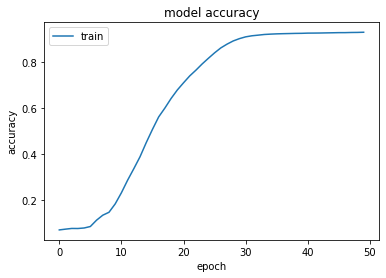

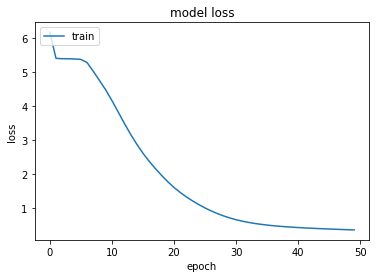

In [ ]:
import matplotlib.pyplot as plt
print(history.history.keys())
plt.plot(history.history['sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [ ]:
def generate_text(model, start_string):

  num_generate = 100

  input_eval = [tokenizer.word_index[s] for s in start_string.split()]
  input_eval_inp = tf.expand_dims(input_eval, 0)
  print(input_eval)
  text_generated = []

  temperature = 1.0

  model.reset_states()
  for i in range(num_generate):
    predictions = model(input_eval_inp)
    
    # remove the batch dimension
    predictions = tf.squeeze(predictions, 0)
    # using a categorical distribution to predict the character returned by the model
    predictions = predictions / temperature
    predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

    
    if predicted_id != 0 :
      input_eval.append(predicted_id)

      s = len(input_eval)
      if s> max_words :
        input_eval = input_eval[(s-max_words):]
       
      input_eval_inp= tf.expand_dims(input_eval, 0)
      text_generated.append(tokenizer.index_word[predicted_id])
      text_generated.append(" ")
    

  return (start_string + ''.join(text_generated))

print(generate_text(model, start_string="i was empty but i could not do nothing . "))

[47, 59, 2121, 28, 47, 119, 17, 84, 154, 7]
i was empty but i could not do nothing . 
 
 
 a explanation , of book , the life is of the spirituality 
 of the slave morality , in the whole , at all men of love to freedom everything 
 who believe in the whole cases has learned . the 
 world more . does it is pride he is certainly not thus 
 love nor moral . of course , and hence the 
 of life , account , of the greatest religions the 
 consequences he are given something than one comes can see 
 every memory , the son . even in the 
